In [1]:
import random
import numpy as np
import torch

from neuralee.embedding import NeuralEE
from neuralee.dataset import HematoDataset
from neuralee._aux import scatter_with_colorbar

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [2]:
hemato_dataset = HematoDataset(save_path='data/HEMATO/')
hemato_dataset.log_shift()
hemato_dataset.subsample_genes(500)  
hemato_dataset.standardscale()

File ../data/HEMATO/bBM.raw_umifm_counts.csv.gz already downloaded
File ../data/HEMATO/data.zip already downloaded
Preprocessing Hemato data
Finished preprocessing Hemato data
Downsampling from 7397 to 500 genes


Compute affinity, perplexity=20.0, on entire dataset
Elastic Embedding, lambda=1, completed in 3.40s, EE loss is 0.327887
Elastic Embedding, lambda=10, completed in 1.49s, EE loss is 1.246657
Compute affinity, perplexity=20.0, N_small=4016, on each batch
Neural Elastic Embedding, lambda=1, completed in 3.24s, EE loss is 0.328114
Neural Elastic Embedding, lambda=10, completed in 3.23s, EE loss is 1.254318
Compute affinity, perplexity=20.0, N_small=2008, on each batch
Neural Elastic Embedding, lambda=1, completed in 3.94s, EE loss is 0.336493
Neural Elastic Embedding, lambda=10, completed in 4.41s, EE loss is 1.290606
Compute affinity, perplexity=20.0, N_small=1004, on each batch
Neural Elastic Embedding, lambda=1, completed in 7.62s, EE loss is 0.347376
Neural Elastic Embedding, lambda=10, completed in 8.29s, EE loss is 1.326361


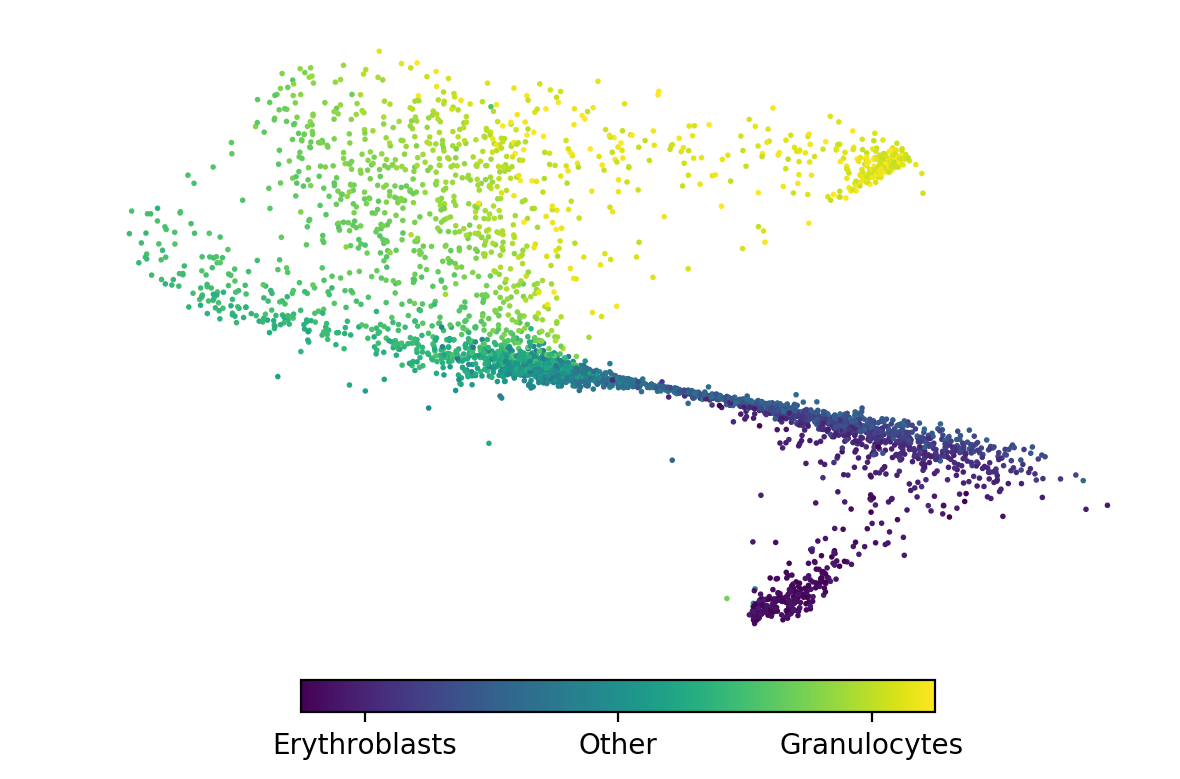

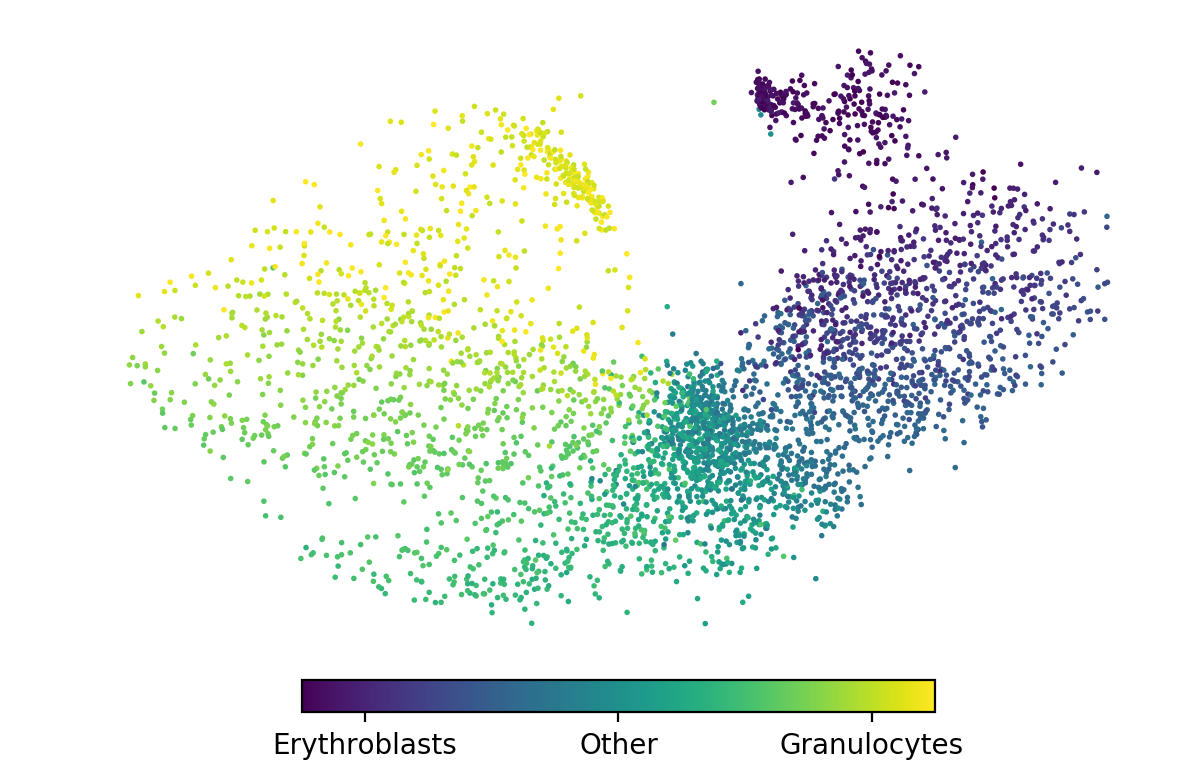

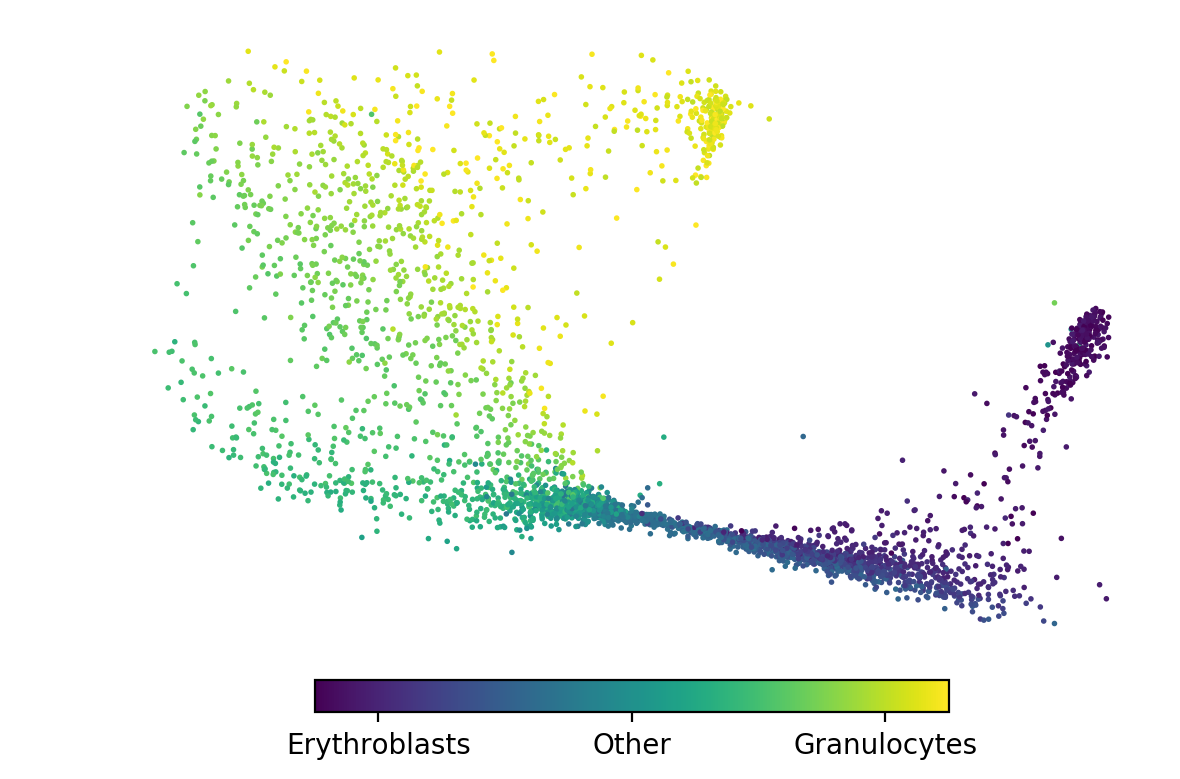

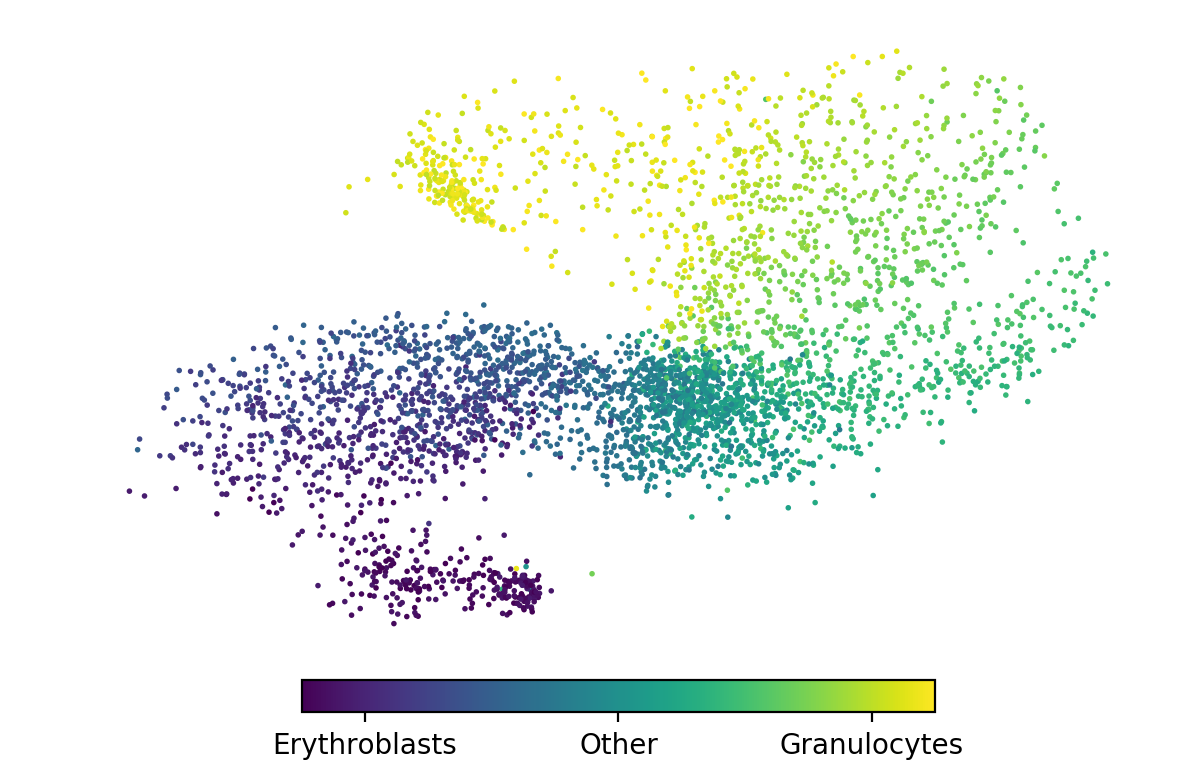

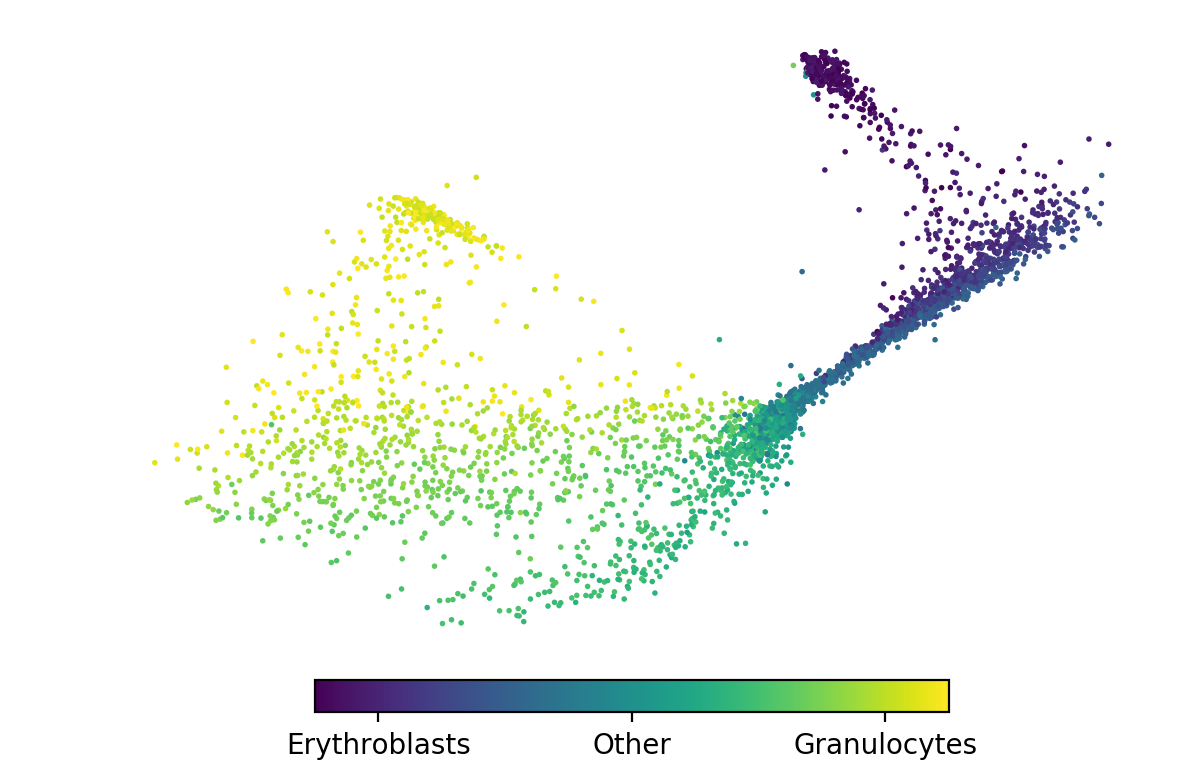

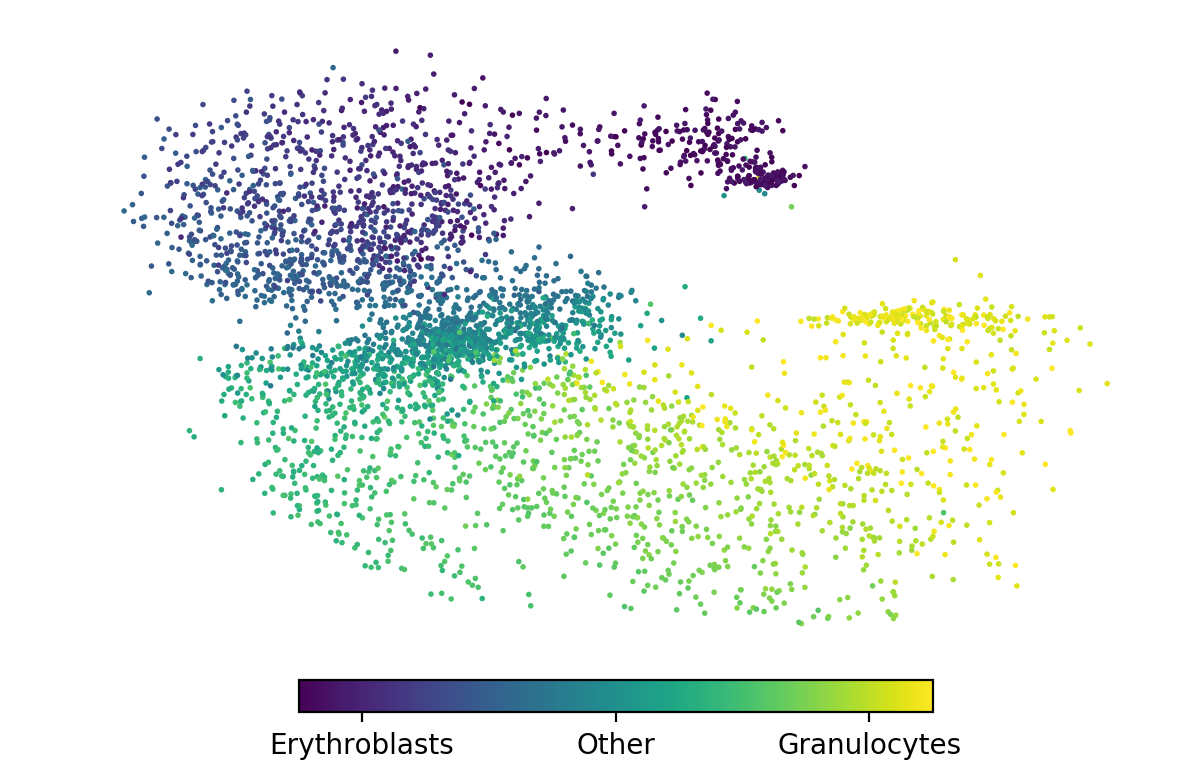

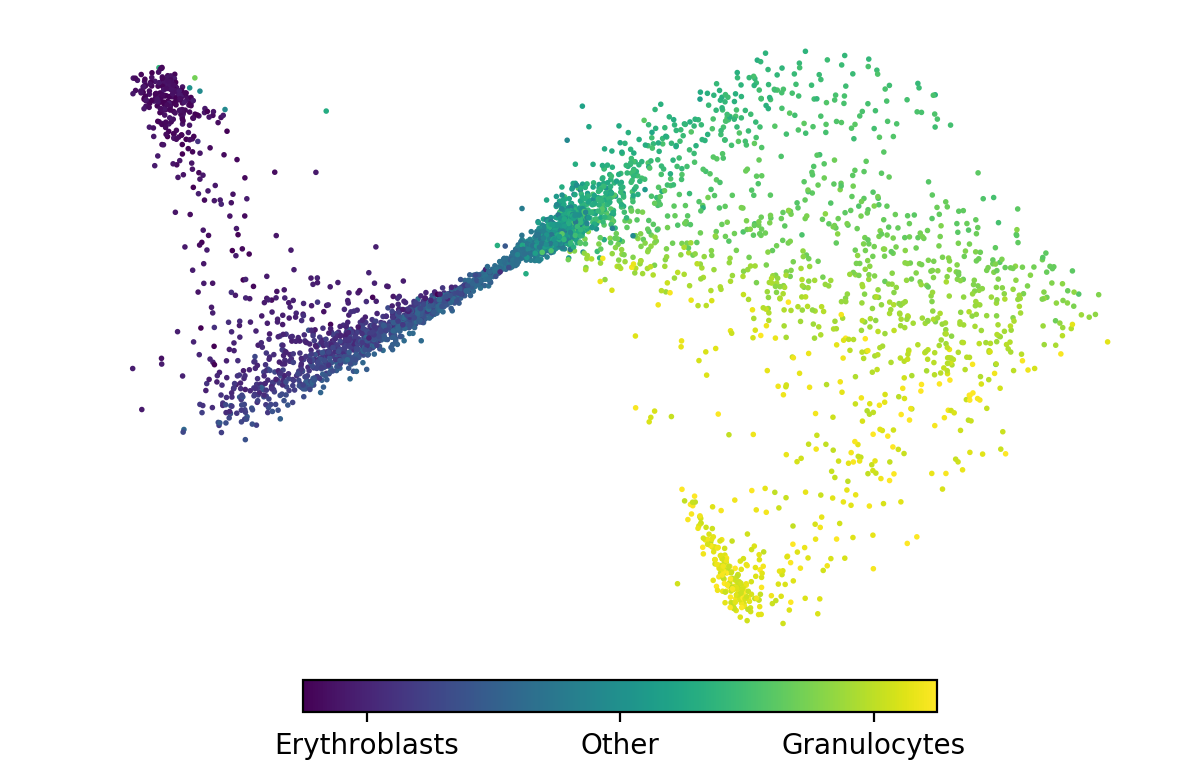

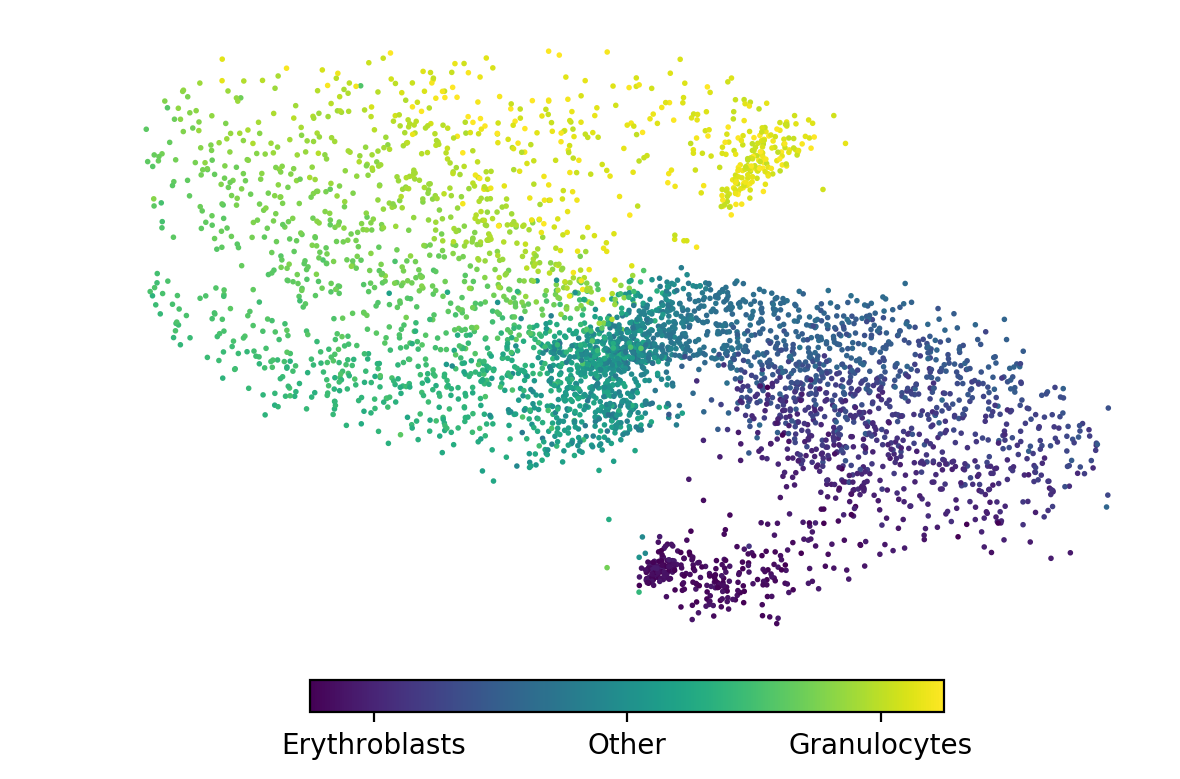

In [3]:
N_smalls = [1.0, 0.5, 0.25]
lams = [1, 10]

hemato_dataset.affinity()
for lam in lams:
    NEE = NeuralEE(hemato_dataset, lam=lam, device=device)
    results = NEE.EE() 
    scatter_with_colorbar(
        results['X'].numpy(), NEE.labels, 
        ['Erythroblasts', 'Granulocytes'])

for N_small in N_smalls:
    hemato_dataset.affinity_split(N_small=N_small)
    for lam in lams:
        NEE = NeuralEE(hemato_dataset, lam=lam, device=device)
        results_Neural = NEE.fine_tune()
        scatter_with_colorbar(
            results_Neural['X'].numpy(), NEE.labels,
            ['Erythroblasts', 'Granulocytes'])